# 示例：轴承故障诊断

In [1]:
import torch
from torch import nn

from fastphm.data import Dataset
from fastphm.data.FeatureExtractor import FeatureExtractor
from fastphm.data.labeler.BearingFaultLabeler import BearingFaultLabeler
from fastphm.data.loader.bearing.XJTULoader import XJTULoader
from fastphm.data.processor.RMSProcessor import RMSProcessor
from fastphm.entity.Bearing import Fault
from fastphm.metric.Evaluator import Evaluator
from fastphm.metric.end2end.Accuracy import Accuracy
from fastphm.metric.end2end.WeightedF1Score import WeightedF1Score
from fastphm.data.stage.BearingStageCalculator import BearingStageCalculator
from fastphm.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from fastphm.model.pytorch.base.BaseTester import BaseTester
from fastphm.model.pytorch.base.BaseTrainer import BaseTrainer
from fastphm.model.pytorch.basic.CNN import CNN
from fastphm.util.Plotter import Plotter

### 定义 数据加载器、特征提取器、fpt计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
stage_calculator = BearingStageCalculator(data_loader.continuum, fpt_calculator)
Plotter.DPI = 80

[DEBUG   14:12:48]  
[DataLoader]  Root directory: D:\data\dataset\XJTU-SY_Bearing_Datasets
	✓ Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	✓ Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	✓ Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	✓ Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	✓ Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	✓ Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	✓ Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	✓ Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	✓ Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	✓ Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	✓ Bearing3_1, location: D:\data\datas

### 构造数据集

In [3]:
fault_types = [Fault.NC, Fault.OF, Fault.IF, Fault.CF]
labeler = BearingFaultLabeler(2048, fault_types, is_multi_hot=False)
dataset = Dataset()
for bearing_name in ['Bearing1_1', 'Bearing1_4', 'Bearing2_1', 'Bearing1_2', 'Bearing2_3']:
    bearing = data_loader(bearing_name, 'Horizontal Vibration')
    feature_extractor(bearing)
    stage_calculator(bearing)
    dataset.add(labeler(bearing))

[INFO    14:12:48]  [DataLoader]  -> Loading data entity: Bearing1_1
[INFO    14:12:51]  [DataLoader]  ✓ Successfully loaded: Bearing1_1
[INFO    14:12:51]  [DataLoader]  -> Loading data entity: Bearing1_4
[INFO    14:12:53]  [DataLoader]  ✓ Successfully loaded: Bearing1_4
[INFO    14:12:53]  [DataLoader]  -> Loading data entity: Bearing2_1
[INFO    14:13:02]  [DataLoader]  ✓ Successfully loaded: Bearing2_1
[INFO    14:13:03]  [DataLoader]  -> Loading data entity: Bearing1_2
[INFO    14:13:06]  [DataLoader]  ✓ Successfully loaded: Bearing1_2
[INFO    14:13:06]  [DataLoader]  -> Loading data entity: Bearing2_3
[INFO    14:13:16]  [DataLoader]  ✓ Successfully loaded: Bearing2_3


### 划分训练数据与测试数据

In [4]:
train_set, test_set = dataset.split_by_ratio(0.7)

### 配置训练算法

In [5]:
train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'epochs': 20,
    'batch_size': 128,
    'lr': 0.01,
    'weight_decay': 0.0,
    'criterion': nn.CrossEntropyLoss(),
}
trainer = BaseTrainer(train_config)

### 定义模型并训练

[INFO    14:13:16]  
[Trainer]  Start training by BaseTrainer:
	training set: Bearing1_1; Bearing1_4; Bearing2_1;…
	device: cuda
	dtype: torch.float32
	epochs: 20
	batch_size: 128
	lr: 0.01
	weight_decay: 0.0
	criterion: CrossEntropyLoss()
	callbacks: []
	optimizer: Adam
[INFO    14:13:17]  [BaseTrainer]  Epoch [1/20], CrossEntropyLoss:0.2655
[INFO    14:13:17]  [BaseTrainer]  Epoch [2/20], CrossEntropyLoss:0.0759
[INFO    14:13:18]  [BaseTrainer]  Epoch [3/20], CrossEntropyLoss:0.0603
[INFO    14:13:18]  [BaseTrainer]  Epoch [4/20], CrossEntropyLoss:0.0497
[INFO    14:13:19]  [BaseTrainer]  Epoch [5/20], CrossEntropyLoss:0.0243
[INFO    14:13:19]  [BaseTrainer]  Epoch [6/20], CrossEntropyLoss:0.0529
[INFO    14:13:19]  [BaseTrainer]  Epoch [7/20], CrossEntropyLoss:0.0163
[INFO    14:13:20]  [BaseTrainer]  Epoch [8/20], CrossEntropyLoss:0.0133
[INFO    14:13:20]  [BaseTrainer]  Epoch [9/20], CrossEntropyLoss:0.0402
[INFO    14:13:20]  [BaseTrainer]  Epoch [10/20], CrossEntropyLoss:0.05

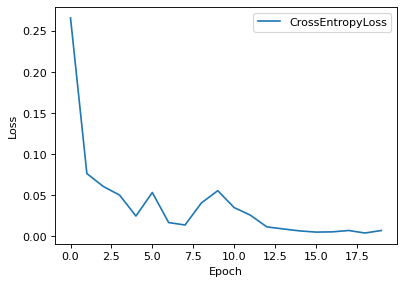

In [6]:
model = CNN(2048, len(fault_types))
losses = trainer.train(model, train_set)
Plotter.loss(losses)

### 预测

In [7]:
tester = BaseTester()
result = tester.test(model, test_set)

### 预测结果评价（故障诊断）

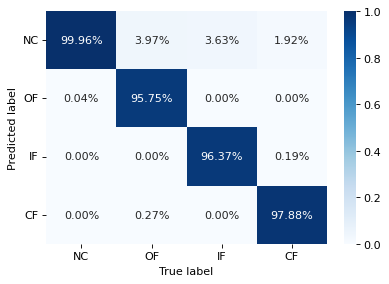

In [8]:
Plotter.confusion_matrix(test_set, result, types=fault_types)

In [9]:
evaluator = Evaluator()
evaluator.add(Accuracy(), WeightedF1Score())
evaluator(test_set, result)

[INFO    14:13:25]  
[Evaluator]  Performance Evaluation:
             Accuracy WeightedF1Score
Bearing1_1     0.9662          0.9659
Bearing1_4     0.9846          0.9823
Bearing2_1     0.9970          0.9970
Bearing1_2     0.9832          0.9845
Bearing2_3     0.9949          0.9949
mean(global)   0.9910          0.9909
mean(group)    0.9910          0.9909



,Accuracy,WeightedF1Score
Bearing1_1,0.9662,0.9659
Bearing1_4,0.9846,0.9823
Bearing2_1,0.9970,0.9970
Bearing1_2,0.9832,0.9845
Bearing2_3,0.9949,0.9949
mean(global),0.9910,0.9909
mean(group),0.9910,0.9909
